In [ ]:
#conda install rasterio
#conda install fiona

In [1]:
import numpy as np
import pandas as pd
import os
import os.path
import fiona
import rasterio
import rasterio.mask
from rasterio.plot import show
from matplotlib import pyplot

In [7]:
path_modis = 'F:/dymaxion/pnud/imagenes/reproyectada/'
path_fuentes = 'F:/dymaxion/pnud/fuentes/'
path_salidas = 'F:/dymaxion/pnud/capa_verde/'

archivo_modis = 'lomas_modis_201408_rep.tif'
archivo_srtm = '1arc_v3_unificado_2.tif'
archivo_srtm_exclusion = '1arc_v3_unificado_2_excl.tif'
archivo_exclusion = 'area_monitoreo_4326_b250.shp' #'area_monitoreo200-1800_04-12-2019.shp'

# Ejemplo MODIS

In [52]:
factor_escala = 0.0001

In [53]:
dataset = rasterio.open(path_modis+archivo_modis)

In [5]:
dataset.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': 0.0,
 'width': 7201,
 'height': 7201,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0002777777777777778, 0.0, -78.00013888888888,
        0.0, -0.0002777777777777778, -10.999861111111112)}

In [54]:
modis_meta = dataset.profile

In [7]:
dataset.indexes

(1,)

In [55]:
modis_ndvi = dataset.read(1)

dataset.close()

In [9]:
modis_ndvi

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
print(np.nanmin(modis_ndvi))
print(np.nanmax(modis_ndvi))
print(np.nanmean(modis_ndvi))


-1989.8558349609375
10886.3212890625
61.50901406596109


In [11]:
print(len(modis_ndvi))
print(len(modis_ndvi[1]))

7201
7201


In [12]:
np.array(np.unique(modis_ndvi, return_counts=True)).T


array([[-1.98985583e+03,  1.00000000e+00],
       [-1.98581738e+03,  1.00000000e+00],
       [-1.98405872e+03,  1.00000000e+00],
       ...,
       [            nan,  1.00000000e+00],
       [            nan,  1.00000000e+00],
       [            nan,  1.00000000e+00]])

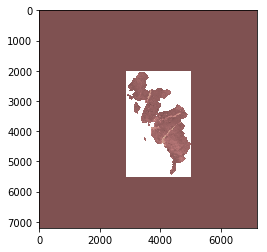

In [13]:
pyplot.imshow(modis_ndvi, cmap='pink')
pyplot.show()

# Ejemplo SRTM

In [4]:
dataset = rasterio.open(path_fuentes+archivo_srtm)

In [14]:
dataset.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': None,
 'width': 7201,
 'height': 7201,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0002777777777777778, 0.0, -78.00013888888888,
        0.0, -0.0002777777777777778, -10.999861111111112)}

In [15]:
dataset.indexes

(1,)

In [5]:
srtm = dataset.read(1)

dataset.close()

In [15]:
print(len(srtm))
print(len(srtm[1]))

7201
7201


In [17]:
print(np.nanmin(srtm))
print(np.nanmax(srtm))
print(np.nanmean(srtm))

-74
5664
1302.3407440768624


In [50]:
np.array(np.unique(srtm, return_counts=True)).T

array([[ -74,    1],
       [ -57,    1],
       [ -44,    1],
       ...,
       [5662,    2],
       [5663,    2],
       [5664,    2]], dtype=int64)

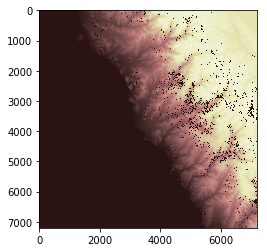

In [23]:
pyplot.imshow(srtm, cmap='pink')
pyplot.show()

### Recorte SRTM

In [30]:
# zonas a excluir
with fiona.open(path_fuentes+archivo_exclusion, "r") as shapefile:
    shp_excl = [feature["geometry"] for feature in shapefile]
shapefile.close() 

# limpia nulos
shp_excl = list(filter(None, shp_excl)) 

# recorte de zonas excluidas srtm
with rasterio.open(path_fuentes+archivo_srtm) as src:
    out_image, out_transform = rasterio.mask.mask(src, shp_excl, crop=True)
    out_meta = src.meta
src.close()                 

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(path_fuentes+archivo_srtm_exclusion, "w", **out_meta) as dest:
    dest.write(out_image)
dest.close() 


# Procesamiento

## Vegetacion

In [37]:
# ndvi < 0.2 suelo desnudo
# ndvi > 0.5 vegetacion
# ndvi entre 0.2 y 0.5 mixto
umbral_ndvi = 0.2
tope = umbral_ndvi / factor_escala # reescala

vegetacion_mask = (modis_ndvi > tope)

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


In [17]:
vegetacion_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [18]:
print(len(vegetacion_mask))
print(len(vegetacion_mask[1]))

7201
7201


In [20]:
np.array(np.unique(vegetacion_mask, return_counts=True)).T

array([[       0, 51674789],
       [       1,   179612]], dtype=int64)

In [19]:
vegetacion_mask.dtype

dtype('bool')

In [38]:
vegetacion = np.copy(modis_ndvi)
vegetacion[~vegetacion_mask] = 0 
#vegetacion = np.ma.masked_array(data=vegetacion,mask=vegetacion_mask)
#vegetacion.filled(0.0)     


In [17]:
vegetacion

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
np.array(np.unique(vegetacion, return_counts=True)).T

array([[0.00000000e+00, 5.16747890e+07],
       [2.00000012e+03, 1.00000000e+00],
       [2.00000659e+03, 1.00000000e+00],
       ...,
       [1.03709170e+04, 1.00000000e+00],
       [1.04960195e+04, 1.00000000e+00],
       [1.08863213e+04, 1.00000000e+00]])

In [19]:
print(len(vegetacion))
print(len(vegetacion[1]))

7201
7201


## Lomas

In [39]:
lomas_min = 200
lomas_max = 1800

lomas_mask = ((srtm >= lomas_min) & (srtm <= lomas_max))

In [24]:
lomas_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [35]:
print(len(lomas_mask))
print(len(lomas_mask[1]))

7201
7201


In [36]:
np.array(np.unique(lomas_mask, return_counts=True)).T

array([[       0, 42666270],
       [       1,  9188131]], dtype=int64)

In [23]:
lomas_mask.dtype

dtype('bool')

In [40]:
lomas = np.copy(srtm)
lomas[~lomas_mask] = 0 


In [23]:
lomas

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [24]:
np.array(np.unique(lomas, return_counts=True)).T

array([[       0, 42666270],
       [     200,     9638],
       [     201,     9802],
       ...,
       [    1798,     3732],
       [    1799,     3892],
       [    1800,     3829]], dtype=int64)

In [40]:
print(len(lomas))
print(len(lomas[1]))

7201
7201


## Capa verde

#### Se define como vegetacion + loma 

In [41]:
verde_mask = (vegetacion_mask & lomas_mask)

In [26]:
verde_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [46]:
print(len(verde_mask))
print(len(verde_mask[1]))

7201
7201


In [28]:
np.array(np.unique(verde_mask, return_counts=True)).T

array([[       0, 51712707],
       [       1,   141694]], dtype=int64)

In [27]:
verde_mask.dtype

dtype('bool')

In [42]:
verde = np.copy(modis_ndvi)
verde[~verde_mask] = 0 

In [49]:
verde

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
np.array(np.unique(verde, return_counts=True)).T

array([[0.00000000e+00, 5.17447360e+07],
       [2.00000012e+03, 1.00000000e+00],
       [2.00000659e+03, 1.00000000e+00],
       ...,
       [1.03709170e+04, 1.00000000e+00],
       [1.04960195e+04, 1.00000000e+00],
       [1.08863213e+04, 1.00000000e+00]])

In [51]:
print(len(verde))
print(len(verde[1]))

7201
7201


In [17]:
print(np.nanmin(verde))
print(np.nanmax(verde))
print(np.nanmean(verde))

0.0
10886.3212890625
5.623072695672914


In [20]:
verde_rango = np.copy(verde)
verde_rango[(verde >= (0.2 / factor_escala)) & (verde < (0.4 / factor_escala))] = 1
verde_rango[(verde >= (0.4 / factor_escala)) & (verde < (0.6 / factor_escala))] = 2
verde_rango[(verde >= (0.6 / factor_escala)) & (verde < (0.8 / factor_escala))] = 3
verde_rango[verde >= (0.8 / factor_escala)] = 4


In [23]:
np.array(np.unique(verde_rango, return_counts=True)).T

array([[0.0000000e+00, 5.1744736e+07],
       [1.0000000e+00, 1.0469500e+05],
       [2.0000000e+00, 4.8430000e+03],
       [3.0000000e+00, 2.3000000e+01],
       [4.0000000e+00, 1.0400000e+02]])

In [ ]:
print(len(verde_rango))
print(len(verde_rango[1]))

In [ ]:
print(np.nanmin(verde_rango))
print(np.nanmax(verde_rango))


## Graficos

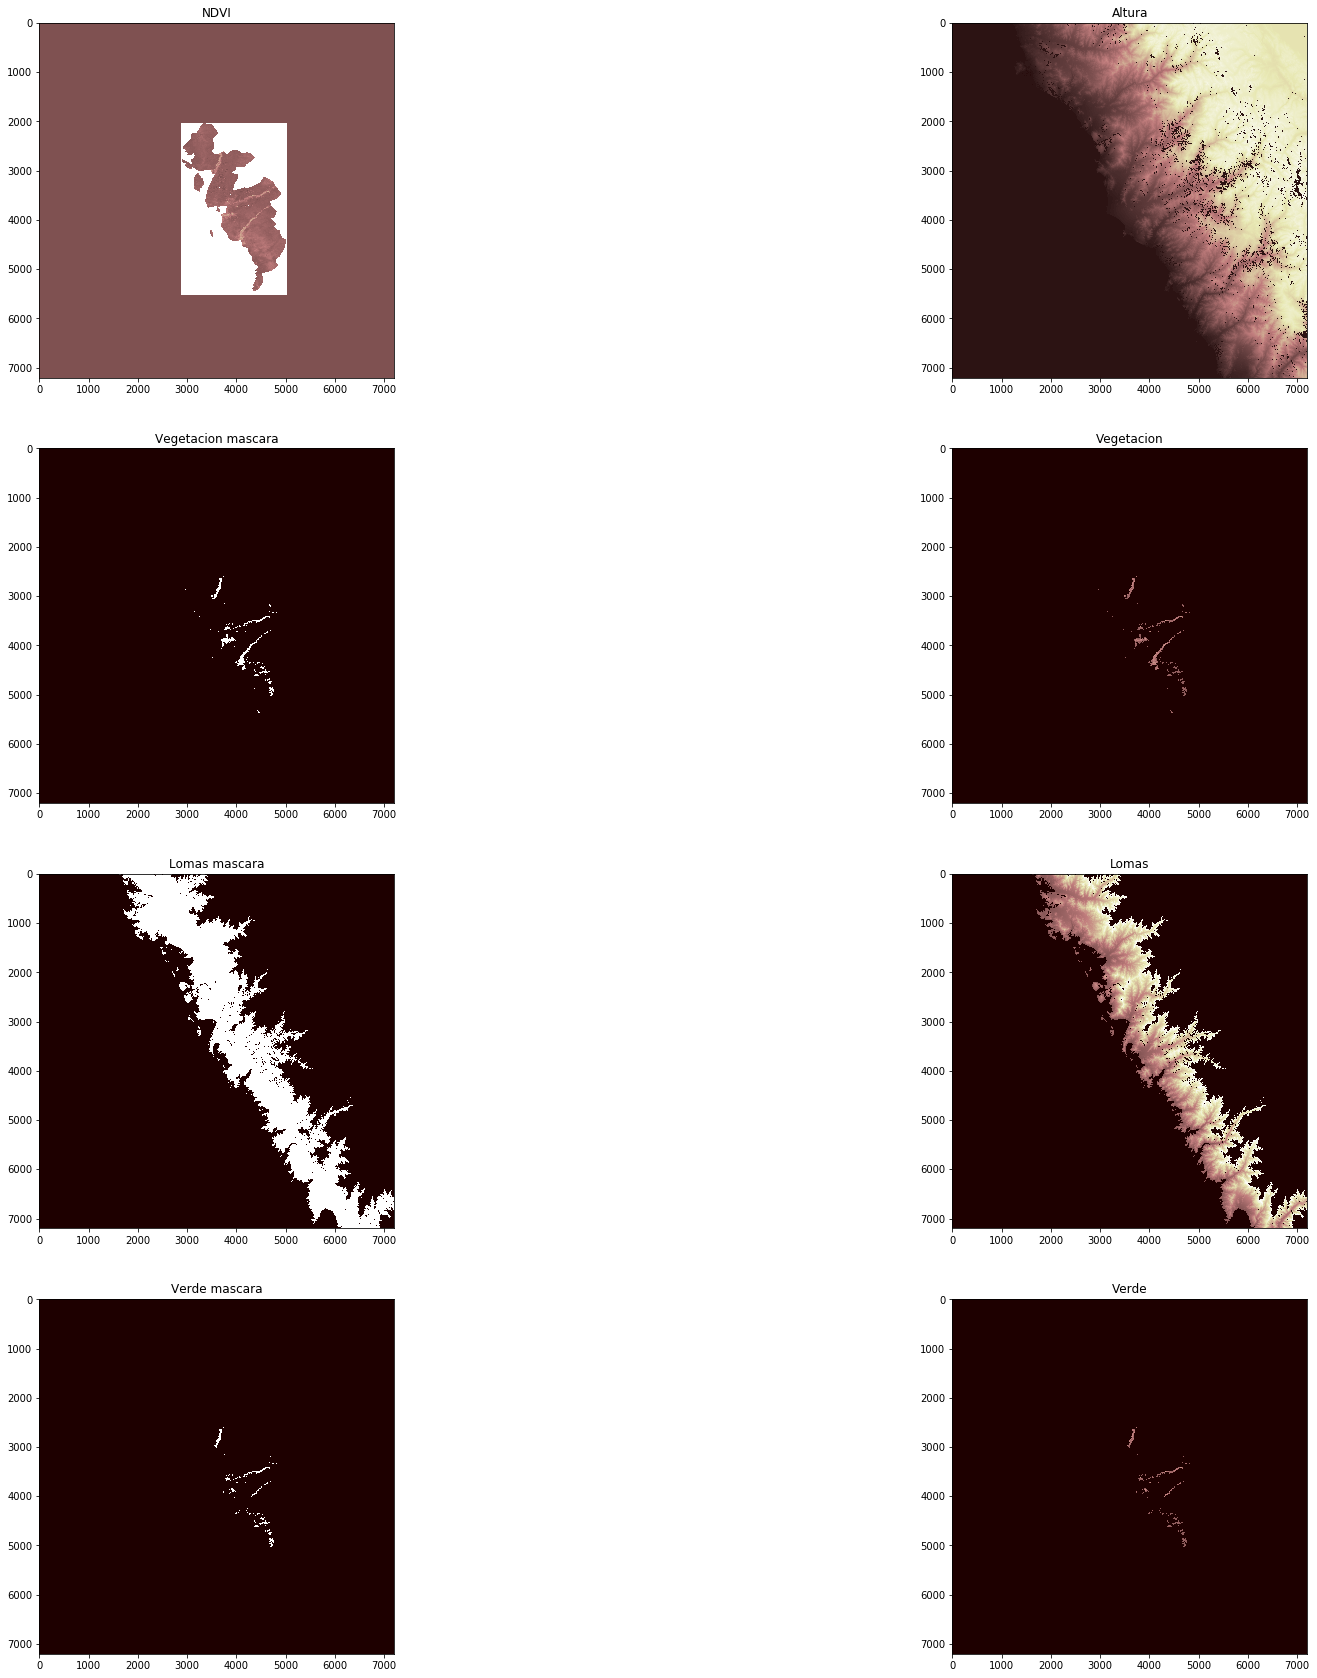

In [15]:
rows = 4
columns = 2
ax = []
fig = pyplot.figure(figsize=(30, 30))

ax.append(fig.add_subplot(rows, columns, 1))
ax[-1].set_title("NDVI")
pyplot.imshow(modis_ndvi, cmap='pink')

ax.append(fig.add_subplot(rows, columns, 2))
ax[-1].set_title("Altura")
pyplot.imshow(srtm, cmap='pink')

ax.append(fig.add_subplot(rows, columns, 3))
ax[-1].set_title("Vegetacion mascara")
pyplot.imshow(vegetacion_mask, cmap='pink')

ax.append(fig.add_subplot(rows, columns, 4))
ax[-1].set_title("Vegetacion")
pyplot.imshow(vegetacion, cmap='pink')

ax.append(fig.add_subplot(rows, columns, 5))
ax[-1].set_title("Lomas mascara")
pyplot.imshow(lomas_mask, cmap='pink')

ax.append(fig.add_subplot(rows, columns, 6))
ax[-1].set_title("Lomas")
pyplot.imshow(lomas, cmap='pink')

ax.append(fig.add_subplot(rows, columns, 7))
ax[-1].set_title("Verde mascara")
pyplot.imshow(verde_mask, cmap='pink')

ax.append(fig.add_subplot(rows, columns, 8))
ax[-1].set_title("Verde")
pyplot.imshow(verde, cmap='pink')

pyplot.show()

# Exportación

In [21]:
modis_meta

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': 0.0, 'width': 7201, 'height': 7201, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -78.00013888888888,
       0.0, -0.0002777777777777778, -10.999861111111112), 'tiled': False, 'interleave': 'band'}

In [43]:
salida_meta = modis_meta

In [19]:
vegetacion_mask_float = np.copy(vegetacion_mask)
vegetacion_mask_float = vegetacion_mask_float + 0.0 # convierte bool a float

with rasterio.open(path_salidas+'201401_vegetacion_mascara.tif', 'w', **salida_meta) as dst:
    dst.write(vegetacion_mask_float, 1)
dst.close()

In [20]:
with rasterio.open(path_salidas+'201401_vegetacion.tif', 'w', **salida_meta) as dst:
    dst.write(vegetacion, 1)
dst.close()

In [21]:
lomas_mask_float = np.copy(lomas_mask)
lomas_mask_float = lomas_mask_float + 0.0 # convierte bool a float

with rasterio.open(path_salidas+'201401_lomas_mascara.tif', 'w', **salida_meta) as dst:
    dst.write(lomas_mask_float, 1)
dst.close()

In [22]:
lomas_float = np.copy(lomas)
lomas_float = lomas_float + 0.0 # convierte int16 a float

with rasterio.open(path_salidas+'201401_lomas.tif', 'w', **salida_meta) as dst:
    dst.write(lomas_float, 1)
dst.close()

In [44]:
salida_meta['dtype'] = "uint8"

verde_mask_int = np.copy(verde_mask)
verde_mask_int = verde_mask_int.astype(np.uint8) 
#print(verde_mask_int.dtype)

#verde_mask_int = verde_mask_int + 0 # convierte bool a int32

with rasterio.open(path_salidas+'201408_verde_mascara.tif', 'w', **salida_meta) as dst:
    dst.write(verde_mask_int, 1)
dst.close()

In [20]:
salida_meta['dtype'] = "float64"

with rasterio.open(path_salidas+'201401_verde.tif', 'w', **salida_meta) as dst:
    dst.write(verde, 1)
dst.close()

In [21]:
with rasterio.open(path_salidas+'201401_verde_rango.tif', 'w', **salida_meta) as dst:
    dst.write(verde_rango, 1)
dst.close()     

## Recorte para excluir zonas agricolas 

In [48]:
with fiona.open(path_fuentes+archivo_exclusion, "r") as shapefile:
    shp_excl = [feature["geometry"] for feature in shapefile]
shapefile.close() 

In [49]:
with rasterio.open(path_salidas+"201408_verde_mascara.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shp_excl, crop=True)
    out_meta = src.meta
src.close()     

In [50]:
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(path_salidas+"201408_test_b50.tif", "w", **out_meta) as dest:
    dest.write(out_image)
dest.close()     

## Procesamiento prueba individual

In [31]:
anio = 2014
mes = 8

In [33]:
# parametros
path_modis = 'F:/dymaxion/pnud/imagenes/reproyectada/'
path_fuentes = 'F:/dymaxion/pnud/fuentes/'
path_salidas = 'F:/dymaxion/pnud/capa_verde/'
archivo_srtm = '1arc_v3_unificado_2.tif'
archivo_srtm_exclusion = '1arc_v3_unificado_2_excl.tif'
archivo_exclusion = 'area_monitoreo_4326_b250.shp' #'area_monitoreo200-1800_04-12-2019.shp'
                     
factor_escala = 0.0001
# umbrales
# ndvi < 0.2 suelo desnudo
# ndvi > 0.5 vegetacion
# ndvi entre 0.2 y 0.5 mixto
umbral_ndvi = 0.2
tope = umbral_ndvi / factor_escala # reescala
lomas_min = 200
lomas_max = 1800
rango1 = 0.2 / factor_escala
rango2 = 0.4 / factor_escala
rango3 = 0.6 / factor_escala
rango4 = 0.8 / factor_escala

# zonas a excluir
with fiona.open(path_fuentes+archivo_exclusion, "r") as shapefile:
    shp_excl = [feature["geometry"] for feature in shapefile]
shapefile.close() 

# limpia nulos
shp_excl = list(filter(None, shp_excl)) 

# recorte de zonas excluidas srtm
with rasterio.open(path_fuentes+archivo_srtm) as src:
    out_image, out_transform = rasterio.mask.mask(src, shp_excl, crop=True)
    out_meta = src.meta
src.close()                 

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(path_fuentes+archivo_srtm_exclusion, "w", **out_meta) as dest:
    dest.write(out_image)
dest.close() 

# srtm
dataset = rasterio.open(path_fuentes+archivo_srtm_exclusion)
srtm = dataset.read(1)
dataset.close()

# modis
if (mes < 10):
    mes = '0'+str(mes)
            
nombre_modis = 'lomas_modis_'+str(anio)+str(mes)+'_rep.tif'
nombre_modis_excl = 'lomas_modis_'+str(anio)+str(mes)+'_rep_excl.tif'
        
if (os.path.exists(path_modis+nombre_modis)):
    # recorte modis de zonas excluidas
    with rasterio.open(path_modis+nombre_modis) as src:
        out_image, out_transform = rasterio.mask.mask(src, shp_excl, crop=True)
        out_meta = src.meta
    src.close()                 

    out_meta.update({"driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform})

    with rasterio.open(path_modis+nombre_modis_excl, "w", **out_meta) as dest:
        dest.write(out_image)
    dest.close()     

    # modis
    dataset = rasterio.open(path_modis+nombre_modis_excl)
    modis_meta = dataset.profile
    modis_ndvi = dataset.read(1)
    dataset.close()

    # vegetacion
    vegetacion_mask = (modis_ndvi > tope)

    # loma
    lomas_mask = ((srtm >= lomas_min) & (srtm <= lomas_max))

    # capa verde
    # mascara
    verde_mask = (vegetacion_mask & lomas_mask)
            
    # ndvi
    verde = np.copy(modis_ndvi)
    verde[~verde_mask] = 0   

    # rangos ndvi
    verde_rango = np.copy(verde)
    verde_rango[(verde >= rango1) & (verde < rango2)] = 1
    verde_rango[(verde >= rango2) & (verde < rango3)] = 2
    verde_rango[(verde >= rango3) & (verde < rango4)] = 3
    verde_rango[verde >= rango4] = 4
            
    # salida
    salida_meta = modis_meta
    salida_meta['dtype'] = "uint8"

    verde_mask_int = np.copy(verde_mask)
    verde_mask_int = verde_mask_int.astype(np.uint8) 

    with rasterio.open(path_salidas+str(anio)+str(mes)+'_verde_mascara_bm250.tif', 'w', **salida_meta) as dst:
        dst.write(verde_mask_int, 1)
    dst.close()

    salida_meta['dtype'] = "float64"
    with rasterio.open(path_salidas+str(anio)+str(mes)+'_verde_bm250.tif', 'w', **salida_meta) as dst:
        dst.write(verde, 1)
    dst.close()            
            
    with rasterio.open(path_salidas+str(anio)+str(mes)+'_verde_rango_bm250.tif', 'w', **salida_meta) as dst:
        dst.write(verde_rango, 1)
    dst.close()

TypeError: '<' not supported between instances of 'str' and 'int'

## Procesamiento lote

In [34]:
anio_inicio = 2014
anio_fin = 2019

In [35]:
path_modis = 'F:/dymaxion/pnud/imagenes/reproyectada/'
path_fuentes = 'F:/dymaxion/pnud/fuentes/'
path_salidas = 'F:/dymaxion/pnud/capa_verde/'
archivo_srtm = '1arc_v3_unificado_2.tif'
archivo_srtm_exclusion = '1arc_v3_unificado_2_excl.tif'
archivo_exclusion = 'area_monitoreo_4326_b250.shp'

factor_escala = 0.0001
# umbrales
# ndvi < 0.2 suelo desnudo
# ndvi > 0.5 vegetacion
# ndvi entre 0.2 y 0.5 mixto
umbral_ndvi = 0.2
tope = umbral_ndvi / factor_escala # reescala
lomas_min = 200
lomas_max = 1800
rango1 = 0.2 / factor_escala
rango2 = 0.4 / factor_escala
rango3 = 0.6 / factor_escala
rango4 = 0.8 / factor_escala

# zonas a excluir
with fiona.open(path_fuentes+archivo_exclusion, "r") as shapefile:
    shp_excl = [feature["geometry"] for feature in shapefile]
shapefile.close() 

# limpia nulos
shp_excl = list(filter(None, shp_excl)) 

# recorte de zonas excluidas srtm
with rasterio.open(path_fuentes+archivo_srtm) as src:
    out_image, out_transform = rasterio.mask.mask(src, shp_excl, crop=True)
    out_meta = src.meta
src.close()                 

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(path_fuentes+archivo_srtm_exclusion, "w", **out_meta) as dest:
    dest.write(out_image)
dest.close() 

# srtm
dataset = rasterio.open(path_fuentes+archivo_srtm_exclusion)
srtm = dataset.read(1)
dataset.close()

for anio in range (anio_inicio, anio_fin+1, 1):
    for mes in range (1, 13, 1):
        print(str(anio)+' '+str(mes))
        
        # modis
        if (mes < 10):
            mes = '0'+str(mes)
            
        nombre_modis = 'lomas_modis_'+str(anio)+str(mes)+'_rep.tif'
        nombre_modis_excl = 'lomas_modis_'+str(anio)+str(mes)+'_rep_excl.tif'
        
        if (os.path.exists(path_modis+nombre_modis)):
            # recorte de zonas excluidas
            with rasterio.open(path_modis+nombre_modis) as src:
                out_image, out_transform = rasterio.mask.mask(src, shp_excl, crop=True)
                out_meta = src.meta
            src.close()                 

            out_meta.update({"driver": "GTiff",
                             "height": out_image.shape[1],
                             "width": out_image.shape[2],
                             "transform": out_transform})

            with rasterio.open(path_modis+nombre_modis_excl, "w", **out_meta) as dest:
                dest.write(out_image)
            dest.close()     

            # modis
            dataset = rasterio.open(path_modis+nombre_modis_excl)
            modis_meta = dataset.profile
            modis_ndvi = dataset.read(1)
            dataset.close()

            # vegetacion
            vegetacion_mask = (modis_ndvi > tope)

            # loma
            lomas_mask = ((srtm >= lomas_min) & (srtm <= lomas_max))

            # capa verde
            # mascara
            verde_mask = (vegetacion_mask & lomas_mask)
            
            # ndvi
            verde = np.copy(modis_ndvi)
            verde[~verde_mask] = 0   

            # rangos ndvi
            verde_rango = np.copy(verde)
            verde_rango[(verde >= rango1) & (verde < rango2)] = 1
            verde_rango[(verde >= rango2) & (verde < rango3)] = 2
            verde_rango[(verde >= rango3) & (verde < rango4)] = 3
            verde_rango[verde >= rango4] = 4
            
            # salida
            salida_meta = modis_meta
            salida_meta['dtype'] = "uint8"

            verde_mask_int = np.copy(verde_mask)
            verde_mask_int = verde_mask_int.astype(np.uint8) 

            with rasterio.open(path_salidas+str(anio)+str(mes)+'_verde_mascara.tif', 'w', **salida_meta) as dst:
                dst.write(verde_mask_int, 1)
            dst.close()

            salida_meta['dtype'] = "float64"
            with rasterio.open(path_salidas+str(anio)+str(mes)+'_verde.tif', 'w', **salida_meta) as dst:
                dst.write(verde, 1)
            dst.close()            
            
            with rasterio.open(path_salidas+str(anio)+str(mes)+'_verde_rango.tif', 'w', **salida_meta) as dst:
                dst.write(verde_rango, 1)
            dst.close()          


2014 1


C:\anaconda3\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in greater


2014 2
2014 3
2014 4
2014 5
2014 6
2014 7
2014 8
2014 9
2014 10
2014 11
2014 12
2015 1
2015 2
2015 3
2015 4
2015 5
2015 6
2015 7
2015 8
2015 9
2015 10
2015 11
2015 12
2016 1
2016 2
2016 3
2016 4
2016 5
2016 6
2016 7
2016 8
2016 9
2016 10
2016 11
2016 12
2017 1
2017 2
2017 3
2017 4
2017 5
2017 6
2017 7
2017 8
2017 9
2017 10
2017 11
2017 12
2018 1
2018 2
2018 3
2018 4
2018 5
2018 6
2018 7
2018 8
2018 9
2018 10
2018 11
2018 12
2019 1
2019 2
2019 3
2019 4
2019 5
2019 6
2019 7
2019 8
2019 9
2019 10
2019 11
2019 12
